In [1]:
import pandas as pd
from model.featurisation import smiles2graph 
from model.CL_model_vas_info import GNNModelWithNewLoss
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

KeyboardInterrupt: 

In [ ]:
df = pd.read_csv('data/freesolv.csv')
df.head()

,smiles,freesolv
0,CN(C)C(=O)c1ccc(cc1)OC,-11.01
1,CS(=O)(=O)Cl,-4.87
2,CC(C)C=C,1.83
3,CCc1cnccn1,-5.45
4,CCCCCCCO,-4.21


In [ ]:
smiles_list = df["smiles"].tolist()
y = df['freesolv'].tolist()
data_list = smiles2graph(
    smiles_list,
    y
)
data_list[0]

Data(x=[13, 79], edge_index=[2, 26], edge_attr=[26, 10], global_features=[5], smiles='CN(C)C(=O)c1ccc(cc1)OC', y=[1, 1])

In [ ]:
def load_model_embeddings(data_list, model_dir):
    model_embeddings = []
    for i in range(3):
        model_path = os.path.join(model_dir, str(i), "best_model.pth")

        # Instantiate model with shape matching input data
        model = GNNModelWithNewLoss(
            num_node_features=data_list[0].x.shape[1],
            num_edge_features=data_list[0].edge_attr.shape[1],
            num_global_features=data_list[0].global_features.shape[0],
            hidden_dim=512
        )

        state_dict = torch.load(model_path, map_location=torch.device("cpu"))
        model.load_state_dict(state_dict['encoder_state_dict'])
        model.eval()

        embeddings = []
        with torch.no_grad():
            for data in data_list:
                emb = model.forward(data.to(torch.device("cpu")))  
                embeddings.append(emb)
        model_embeddings.append(torch.stack(embeddings))
    return model_embeddings

In [ ]:
def prepare_dataset(smiles2graph_fn, csv_file, model_dir):
    df = pd.read_csv(csv_file)
    smiles_list = df["smiles"].tolist()
    y = torch.tensor(df["freesolv"].values, dtype=torch.float32)
    data_list = smiles2graph_fn(smiles_list, y)
    embeddings = load_model_embeddings(data_list, model_dir)
    return embeddings, y

In [ ]:
embeddings, y_tensor = prepare_dataset(smiles2graph, "data/freesolv.csv", "models")


c:\Users\27476\Documents\GitHub\clean_multi_cl\model\featurisation.py:216: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_val, dtype=torch.float).view(1, -1)
C:\Users\27476\AppData\Local\Temp\ipykernel_16424\1711103243.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly 

In [ ]:
embeddings = torch.stack(embeddings, dim=0)
embeddings = embeddings.squeeze(2)
embeddings = embeddings.permute(1, 0, 2)
embeddings.shape

torch.Size([642, 3, 512])

In [ ]:
y_tensor.shape

torch.Size([642])

In [ ]:
N = embeddings.size(0)
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size
generator  = torch.Generator().manual_seed(42)
full_ds = torch.utils.data.TensorDataset(embeddings, y_tensor)
train_ds, val_ds, test_ds = random_split(full_ds, [train_size, val_size, test_size], generator=generator)

In [ ]:
class MolDataset(Dataset):
    def __init__(self, embeddings, targets):
        self.X = torch.from_numpy(embeddings).float()
        self.y = torch.from_numpy(targets).float()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=32,
    num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_ds, batch_size=32,
    num_workers=2, pin_memory=True
)

In [ ]:
class TransformerFusionModel(nn.Module):
    def __init__(self, emb_dim, hidden_dim=64):
        super().__init__()
        self.k_proj = nn.Linear(emb_dim, emb_dim)
        self.v_proj = nn.Linear(emb_dim, emb_dim)
        self.query  = nn.Parameter(torch.randn(emb_dim))
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        B, N, D = x.size()
        K = self.k_proj(x)
        V = self.v_proj(x)
        Q = self.query.unsqueeze(0).unsqueeze(1).expand(B, 1, D)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(D)
        weights = torch.softmax(scores, dim=-1)
        fused = torch.matmul(weights, V).squeeze(1)
        out = self.mlp(fused).squeeze(-1)
        return out, weights.squeeze(1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb_dim   = embeddings.shape[-1]
model     = TransformerFusionModel(emb_dim=emb_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 300
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    model.train()
    total_train = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        preds, _ = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train += loss.item() * xb.size(0)
    train_losses.append((total_train / len(train_ds))**0.5)

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            preds, _ = model(xb)
            total_val += criterion(preds, yb).item() * xb.size(0)
    val_losses.append((total_val / len(val_ds))**0.5)
    print(f"Epoch {epoch}/{epochs} — Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/300 — Train Loss: 5.3174, Val Loss: 5.0661
Epoch 2/300 — Train Loss: 4.9433, Val Loss: 4.4949
Epoch 3/300 — Train Loss: 4.1757, Val Loss: 3.8051
Epoch 4/300 — Train Loss: 3.6717, Val Loss: 3.6455
Epoch 5/300 — Train Loss: 3.5194, Val Loss: 3.4333
Epoch 6/300 — Train Loss: 3.3740, Val Loss: 3.2610
Epoch 7/300 — Train Loss: 3.2252, Val Loss: 3.1302
Epoch 8/300 — Train Loss: 3.0058, Val Loss: 2.9604
Epoch 9/300 — Train Loss: 2.9537, Val Loss: 2.8975
Epoch 10/300 — Train Loss: 2.8534, Val Loss: 2.7989
Epoch 11/300 — Train Loss: 2.8226, Val Loss: 2.7873
Epoch 12/300 — Train Loss: 2.6812, Val Loss: 2.7139
Epoch 13/300 — Train Loss: 2.6602, Val Loss: 2.6659
Epoch 14/300 — Train Loss: 2.4840, Val Loss: 2.8386
Epoch 15/300 — Train Loss: 2.3951, Val Loss: 2.4622
Epoch 16/300 — Train Loss: 2.2533, Val Loss: 2.4227
Epoch 17/300 — Train Loss: 2.1695, Val Loss: 2.3353
Epoch 18/300 — Train Loss: 1.9621, Val Loss: 2.3192
Epoch 19/300 — Train Loss: 1.9897, Val Loss: 2.4498
Epoch 20/300 — Train 

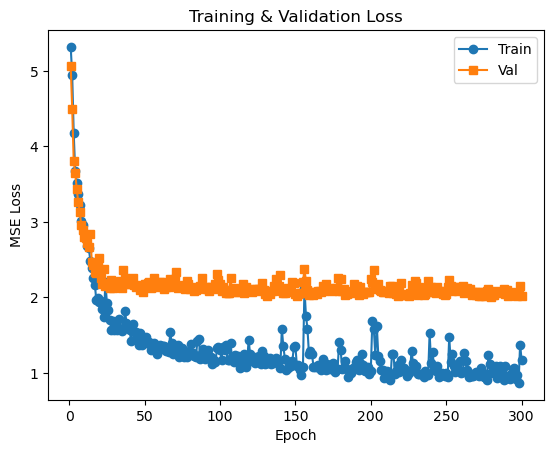

Test Loss: 1.4301
Test Loss: 1.3206
Test Loss: 1.5186
Test Loss: 1.5299


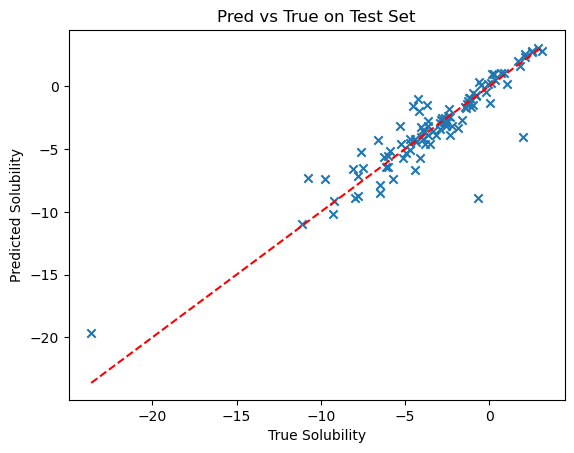

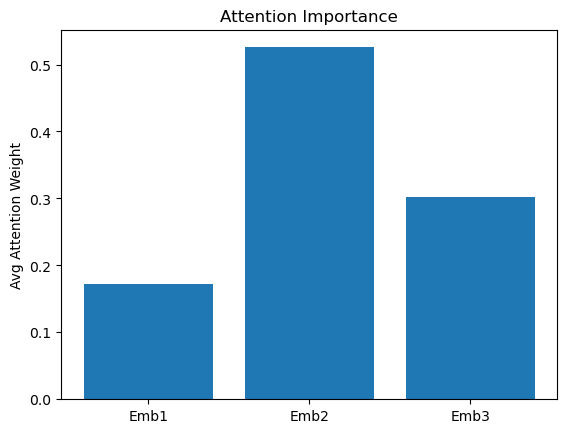

In [ ]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Train')
plt.plot(range(1, epochs+1), val_losses,   marker='s', label='Val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

model.eval()
y_true, y_pred, attn_list = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        preds, weights = model(xb)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        attn_list.append(weights.cpu().numpy())
        test_loss = criterion(torch.tensor(y_pred, device=device), torch.tensor(y_true, device=device))**0.5
        print(f"Test Loss: {test_loss.item():.4f}")
attn = np.vstack(attn_list)

plt.figure()
plt.scatter(y_true, y_pred, marker='x')
mn, mx = min(y_true), max(y_true)
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('True Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Pred vs True on Test Set')
plt.show()

avg_weights = attn.mean(axis=0)
plt.figure()
plt.bar(['Emb1','Emb2','Emb3'], avg_weights)
plt.ylabel('Avg Attention Weight')
plt.title('Attention Importance')
plt.show()

In [ ]:
class MLP(nn.Module):
    def __init__(self, emb_dim, hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out = self.mlp(x).squeeze(-1)
        return out

In [ ]:
for xb, yb in train_loader:
    xb = torch.cat([xb[:, i, :] for i in range(xb.size(1))], dim=1)
    print(xb.shape)
    break

torch.Size([32, 1536])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb_dim   = embeddings.shape[-1]*3
model     = MLP(emb_dim=emb_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 300
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    model.train()
    total_train = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        xb = torch.cat([xb[:, i, :] for i in range(xb.size(1))], dim=1)
        yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train += loss.item() * xb.size(0)
    train_losses.append((total_train / len(train_ds))**0.5)

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device, non_blocking=True)
            xb = torch.cat([xb[:, i, :] for i in range(xb.size(1))], dim=1)
            yb = yb.to(device, non_blocking=True)
            preds = model(xb)
            total_val += criterion(preds, yb).item() * xb.size(0)
    val_losses.append((total_val / len(val_ds))**0.5)
    print(f"Epoch {epoch}/{epochs} — Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/300 — Train Loss: 5.3985, Val Loss: 5.0830
Epoch 2/300 — Train Loss: 4.9355, Val Loss: 4.4908
Epoch 3/300 — Train Loss: 4.1979, Val Loss: 3.9054
Epoch 4/300 — Train Loss: 3.7574, Val Loss: 3.7194
Epoch 5/300 — Train Loss: 3.5311, Val Loss: 3.5126
Epoch 6/300 — Train Loss: 3.4096, Val Loss: 3.4126
Epoch 7/300 — Train Loss: 3.3693, Val Loss: 3.2918
Epoch 8/300 — Train Loss: 3.1628, Val Loss: 3.2006
Epoch 9/300 — Train Loss: 3.1457, Val Loss: 3.1209
Epoch 10/300 — Train Loss: 3.0787, Val Loss: 3.0534
Epoch 11/300 — Train Loss: 3.1218, Val Loss: 3.0197
Epoch 12/300 — Train Loss: 2.9442, Val Loss: 2.9518
Epoch 13/300 — Train Loss: 2.9068, Val Loss: 2.8711
Epoch 14/300 — Train Loss: 2.8434, Val Loss: 2.8076
Epoch 15/300 — Train Loss: 2.8013, Val Loss: 2.7596
Epoch 16/300 — Train Loss: 2.7803, Val Loss: 2.7142
Epoch 17/300 — Train Loss: 2.7157, Val Loss: 2.6753
Epoch 18/300 — Train Loss: 2.5878, Val Loss: 2.6421
Epoch 19/300 — Train Loss: 2.6306, Val Loss: 2.6008
Epoch 20/300 — Train 

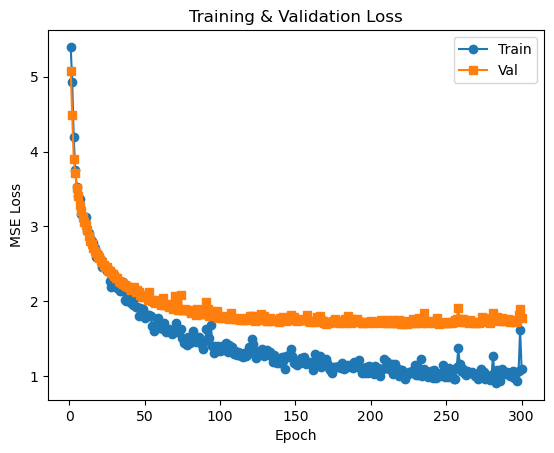

Test Loss: 1.1583
Test Loss: 1.3875
Test Loss: 1.4271
Test Loss: 1.4474


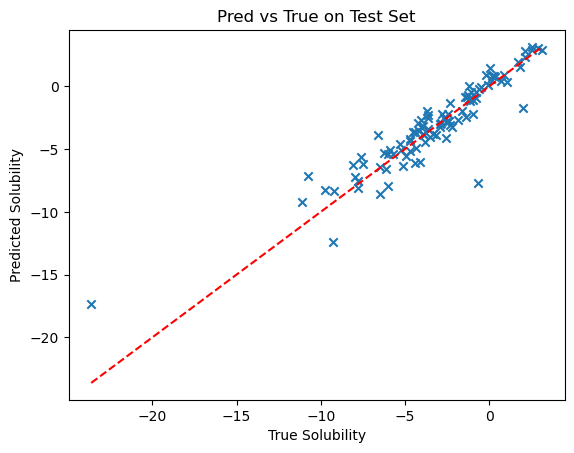

In [ ]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Train')
plt.plot(range(1, epochs+1), val_losses,   marker='s', label='Val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

model.eval()
y_true, y_pred, attn_list = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        xb = torch.cat([xb[:, i, :] for i in range(xb.size(1))], dim=1)
        yb = yb.to(device, non_blocking=True)
        preds = model(xb)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        attn_list.append(weights.cpu().numpy())
        test_loss = criterion(torch.tensor(y_pred, device=device), torch.tensor(y_true, device=device))**0.5
        print(f"Test Loss: {test_loss.item():.4f}")
attn = np.vstack(attn_list) 

plt.figure()
plt.scatter(y_true, y_pred, marker='x')
mn, mx = min(y_true), max(y_true)
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('True Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Pred vs True on Test Set')
plt.show()

In [ ]:
class WeightedFusion(nn.Module):
    def __init__(self, num_inputs=3, emb_dim=512, dropout=0.1, layer_norm_out=True):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_inputs = num_inputs
        self.linear = nn.Sequential(
            nn.Linear(emb_dim, emb_dim), nn.ReLU(),
            nn.Linear(emb_dim, emb_dim)
        )
        self.weight_logits = nn.Parameter(torch.zeros(num_inputs))  # initialized to uniform weights
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(emb_dim) if layer_norm_out else None
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, embs):  # embs: [B, N, D]
        B, N, D = embs.size()
        x = self.linear(embs)  # shape [B, N, D]
        norm_weights = torch.softmax(self.weight_logits, dim=0)  # shape [N]
        fused = torch.einsum('bnd,n->bd', x, norm_weights)  # [B, D]
        fused = self.dropout(fused)
        if self.layer_norm is not None:
            fused = self.layer_norm(fused)
        out = self.mlp(fused).squeeze(-1)
        return out, norm_weights

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb_dim   = embeddings.shape[-1]
model     = WeightedFusion(emb_dim=emb_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-5)

epochs = 100
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    model.train()
    total_train = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        preds, _ = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train += loss.item() * xb.size(0)
    train_losses.append((total_train / len(train_ds))**0.5)

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            preds, _ = model(xb)
            total_val += criterion(preds, yb).item() * xb.size(0)
    val_losses.append((total_val / len(val_ds))**0.5)
    print(f"Epoch {epoch}/{epochs} — Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/100 — Train Loss: 5.4691, Val Loss: 5.2584
Epoch 2/100 — Train Loss: 5.3204, Val Loss: 5.1034
Epoch 3/100 — Train Loss: 5.1531, Val Loss: 4.9165
Epoch 4/100 — Train Loss: 4.9479, Val Loss: 4.7292
Epoch 5/100 — Train Loss: 4.7487, Val Loss: 4.5161
Epoch 6/100 — Train Loss: 4.5294, Val Loss: 4.3116
Epoch 7/100 — Train Loss: 4.3029, Val Loss: 4.1407
Epoch 8/100 — Train Loss: 4.1350, Val Loss: 4.0161
Epoch 9/100 — Train Loss: 3.9436, Val Loss: 3.9172
Epoch 10/100 — Train Loss: 3.8953, Val Loss: 3.8383
Epoch 11/100 — Train Loss: 3.7674, Val Loss: 3.7110
Epoch 12/100 — Train Loss: 3.6411, Val Loss: 3.5555
Epoch 13/100 — Train Loss: 3.5217, Val Loss: 3.3949
Epoch 14/100 — Train Loss: 3.3429, Val Loss: 3.2694
Epoch 15/100 — Train Loss: 3.1989, Val Loss: 3.1465
Epoch 16/100 — Train Loss: 3.1780, Val Loss: 2.9984
Epoch 17/100 — Train Loss: 3.1059, Val Loss: 2.8709
Epoch 18/100 — Train Loss: 3.0115, Val Loss: 2.7924
Epoch 19/100 — Train Loss: 2.8030, Val Loss: 2.7056
Epoch 20/100 — Train 

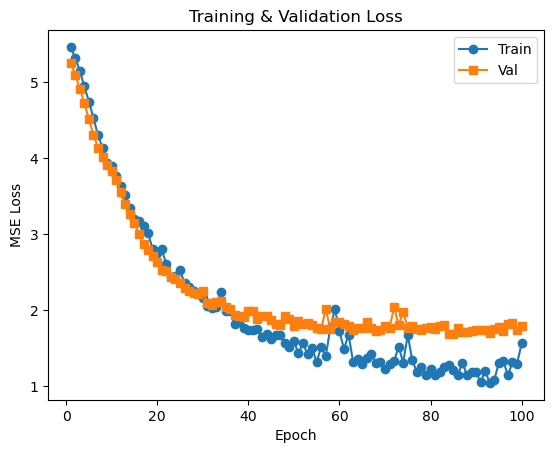

Test Loss: 1.3619
Test Loss: 1.5248
Test Loss: 1.5645
Test Loss: 1.5928


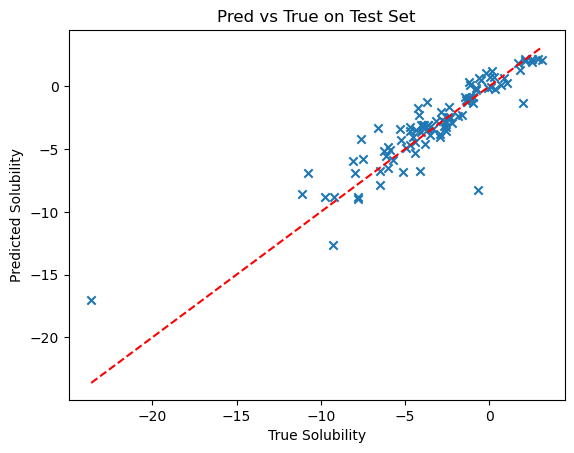

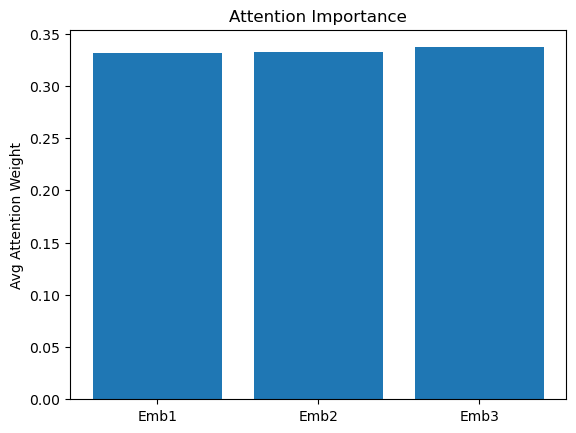

: 

In [ ]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Train')
plt.plot(range(1, epochs+1), val_losses,   marker='s', label='Val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

model.eval()
y_true, y_pred, attn_list = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        preds, weights = model(xb)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        attn_list.append(weights.cpu().numpy())
        test_loss = criterion(torch.tensor(y_pred, device=device), torch.tensor(y_true, device=device))**0.5
        print(f"Test Loss: {test_loss.item():.4f}")
attn = np.vstack(attn_list)

plt.figure()
plt.scatter(y_true, y_pred, marker='x')
mn, mx = min(y_true), max(y_true)
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('True Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Pred vs True on Test Set')
plt.show()

avg_weights = attn.mean(axis=0)
plt.figure()
plt.bar(['Emb1','Emb2','Emb3'], avg_weights)
plt.ylabel('Avg Attention Weight')
plt.title('Attention Importance')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np

def load_data_for_visualization(name, batch_size=32, val_split=0.1, test_split=0.2, seed=42):
    df = pd.read_csv(f'data/{name}.csv')
    smiles_list = df['smiles'].tolist()
    labels = df[name].tolist()

    data_list = smiles2graph(smiles_list, labels)

    train_val, test_data = train_test_split(data_list, test_size=test_split, random_state=seed)
    train_data, val_data = train_test_split(
        train_val, test_size=val_split/(1 - test_split), random_state=seed
    )

    train_loader = GeoDataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = GeoDataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = GeoDataLoader(test_data, batch_size=batch_size, shuffle=False)

    test_smiles_list = [data.smiles for data in test_data]

    return train_loader, val_loader, test_loader, test_smiles_list


def plot_best_and_worst(preds, labs, smiles_list, dataset_name, fusion_method, out_dir='results'):
    # Ensure smiles_list length matches the preds and labs lengths
    assert len(preds) == len(labs) == len(smiles_list), "Preds, labs, and smiles_list must have the same length."
    
    # Calculate the differences
    diffs = np.abs(preds - labs)
    
    # Sort based on the differences (for both best and worst)
    best_indices = np.argsort(diffs)[:15]  
    worst_indices = np.argsort(diffs)[-15:]  
    
    # Prepare data for plotting
    best_preds, best_labs = preds[best_indices], labs[best_indices]
    worst_preds, worst_labs = preds[worst_indices], labs[worst_indices]
    best_smiles, worst_smiles = [smiles_list[i] for i in best_indices], [smiles_list[i] for i in worst_indices]

    # Create a PDF to save the plots
    pdf_path = f'{out_dir}/{dataset_name}_{fusion_method}_best_worst_2.pdf'
    with PdfPages(pdf_path) as pdf:
        # Plot for best 15 molecules
        fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3x5 grid for best 15 molecules
        axes = axes.flatten()
        for i, (smiles, pred, lab) in enumerate(zip(best_smiles, best_preds, best_labs)):
            mol = Chem.MolFromSmiles(smiles)
            img = Draw.MolToImage(mol, size=(200, 200))  # Resize the image to ensure consistent display
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Pred: {pred:.2f}\nTrue: {lab:.2f}", fontsize=10)
        
        plt.suptitle(f'{dataset_name} - {fusion_method} - Best 15 Molecules', fontsize=16)
        pdf.savefig()  # Save the plot to the PDF
        plt.close()

        # Plot for worst 15 molecules
        fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3x5 grid for worst 15 molecules
        axes = axes.flatten()
        for i, (smiles, pred, lab) in enumerate(zip(worst_smiles, worst_preds, worst_labs)):
            mol = Chem.MolFromSmiles(smiles)
            img = Draw.MolToImage(mol, size=(200, 200))  # Resize the image to ensure consistent display
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Pred: {pred:.2f}\nTrue: {lab:.2f}", fontsize=10)
        
        plt.suptitle(f'{dataset_name} - {fusion_method} - Worst 15 Molecules', fontsize=16)
        pdf.savefig()  # Save the plot to the PDF
        plt.close()
        
    print(f"Best and worst plots saved to {pdf_path}")


def run_and_plot(fusion_method, dataset, best_params, out_dir):
    # Load data
    tr, vl, te, tsl = load_data_for_visualization(
    dataset, batch_size=best_params['batch_size'], 
    val_split=best_params['val_split'], test_split=best_params['test_split'], seed=42)

    sample = tr.dataset[0]
    
    # Get model
    model = get_finetune_model(fusion_method, sample, dropout=best_params['dropout'])
    
    # Train the model
    tr_losses, val_rmses = train_and_validate(model, tr, vl, epochs=best_params['epochs'])
    
    # Test the model
    rmse_test, preds, labs = test_model(model, te)
    
    # Plot and save best and worst molecules
    plot_best_and_worst(preds, labs, tsl, fusion_method, out_dir)
best_params = {
    'batch_size': 16,
    'val_split': 0.1,
    'test_split': 0.2,
    'epochs': 100,
    'dropout': 0.3,
    'seed': 42,
    'weight_decay': 0,
}

out_dir = 'results'
run_and_plot('attention', 'freesolv', best_params, out_dir)
